# Research Question 3:
## Reducing Dimensionality of our Dataset and Clustering
#### Jameson Carter
#### 12/5/2021
The dataset obtained in 7_CombineData.ipynb has more than 100 variables. This code uses PCA analysis to reduce the dimensionality of our dataset and reduce collinearity, using scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

The purpose of this process is to explore the two components of our third research question:
 - Can we effectively cluster census tracts into groups with similar characteristics (unsupervised learning)
 - Do census tracts in a given cluster have similar outcomes in terms of use of force complaints

## Importing Data and Fitting Initial K-Means Clustering
To start, I import the data and perform a regular K means clustering process, to see whether PCA is even necessary. I check to see whether there is an optimal K for the entire dataset (except for the non-numeric variables, as these will not be applicable to PCA).

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from yellowbrick.features import RadViz

In [120]:
# Replace following dataset with the correct filepath
data = pd.read_csv('C:/Users/jacar/OneDrive/Documents/chicago-complaints/data/Combined.csv')
data = data.drop(['geo_id', 'geometry', 'GEOID10'], axis = 1)

y = data['complaint_count']
# Drop the geographic variables because they are not numerical or ordinal
# Via: https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6
X = data.drop(['complaint_count','lakeMI_qmile','river_qmile','Rail_emile','MajorRd_qmile'], axis = 1)

#### An Initial K-Means Cluster Model
The following two plots find ideal K for K-means modeling using Distortion Scores and Calinski Harabasz Scores. The two plots do not agree, as Distortion Scores suggest a K of 5 and Calinski Harabasz suggest a K of 13. I test both to see whether they produce suitable clusters.

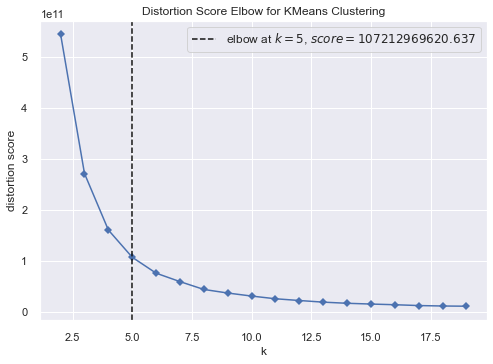

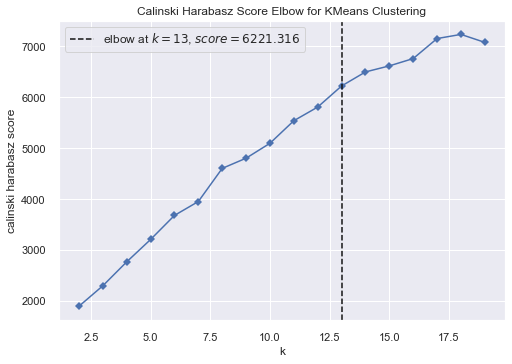

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [121]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False)
visualizer.fit(X)
visualizer.show()

visualizer = KElbowVisualizer(model, k=(2,20), metric='calinski_harabasz',locate_elbow=True, timings=False)
visualizer.fit(X)
visualizer.show()

#### Initial Model at K = 5
The following finds large variation in cluster size via the silhouette plot, and overlap in three of the clusters, all of which are the largest. This does not seem suitable.

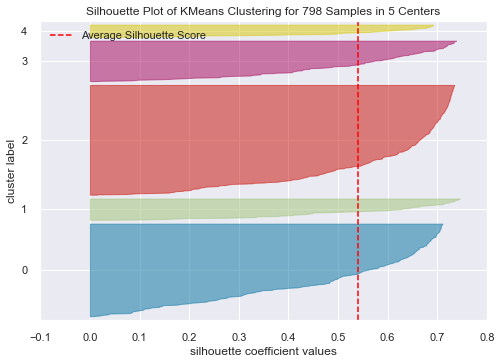

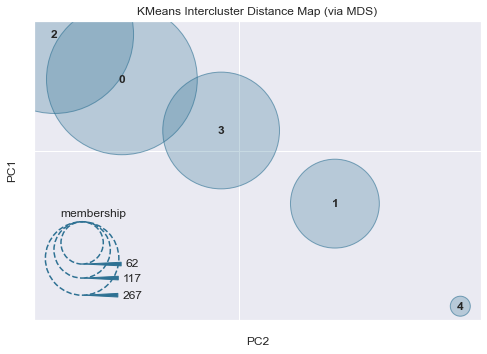

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [122]:
modeldist = KMeans(random_state=1, n_clusters = 5)

visualizer = SilhouetteVisualizer(modeldist, colors='yellowbrick')
visualizer.fit(X) 
visualizer.show()    

visualizer = InterclusterDistance(modeldist, colors='yellowbrick')
visualizer.fit(X) 
visualizer.show()   

#### Initial Model at K = 13
The following finds large variation in cluster size via the silhouette plot, and overlap among all of the clusters besides one very small cluster in the Intercluster Distance map. This also appears to be a bad clustering method.

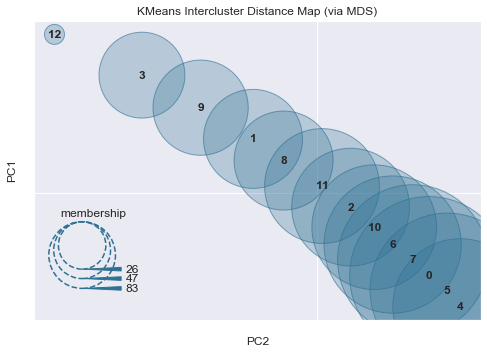

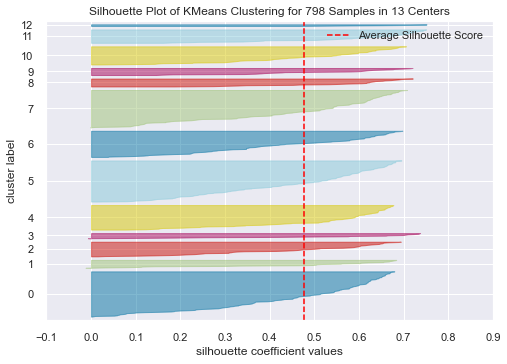

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 798 Samples in 13 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [123]:
modelch = KMeans(random_state=1, n_clusters = 13)
visualizer = InterclusterDistance(modelch, colors='yellowbrick')
visualizer.fit(X) 
visualizer.show()

visualizer = SilhouetteVisualizer(modelch, colors='yellowbrick')
visualizer.fit(X) 
visualizer.show()

## Begin PCA Process by Standardizing Relevant Features
It is possible that the overlap in clusters is a function of high dimensionality in the data, among many highly-correlated features, and that therefore this exercise would benefit from a PCA analysis. PCA can reduce noise in the data and produce a reasonable approximation of the data at a lower dimension. This works particularly well if the data, in the presence of high multicollinearity, is essentially low in dimension. In this section, I standardize data for use in a PCA model and then continue on with further analysis.

In [124]:
scaler = StandardScaler()
scaledSubs=scaler.fit(X).transform(X)

In [125]:
print(f'Did standardizing the data to ~N(0,1) work?\n'
      f'Mean is roughly {round(scaledSubs.mean())},\nStdev is exactly {scaledSubs.std()}')

Did standardizing the data to ~N(0,1) work?
Mean is roughly 0,
Stdev is exactly 1.0


### Fitting PCA and identifying ideal number of PCs
In this section, I use the standardized data to determine the optimal number of PCs for this analysis, and fit a PCA model to the data with their dimensionality reduced. 

In [126]:
'''
From https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
The below parameter is set to 0.95 so that we find the minimum number of principal components such that 95% 
of the variance is retained.
'''
pca = PCA()
pca.fit(scaledSubs)

PCA()

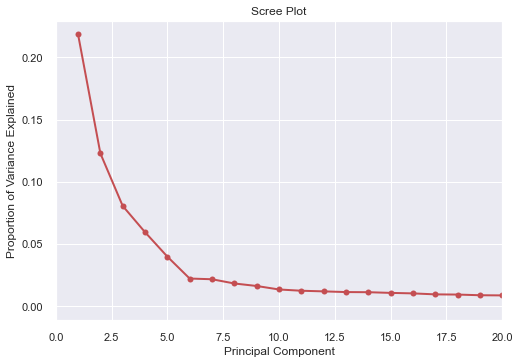

In [127]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot') 
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xlim([0, 20])
plt.show()

The above scree plot suggests that we keep 6 principal components, or potentially even more, because the elbow point is observable clearly at 6 PCs, however the slope declines again before leveling off. I will go with 6.

In [128]:
pca = PCA(n_components = 6)
reduced_data = pca.fit_transform(scaledSubs)

### Finding Optimal K given dimensionality-reduced data
In this section, I use the reduced data to cluster on K-means, to see what the optimal K-means n should be.

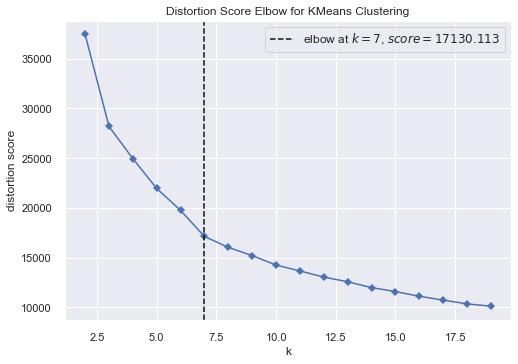

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [129]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False)
visualizer.fit(reduced_data)
visualizer.show()

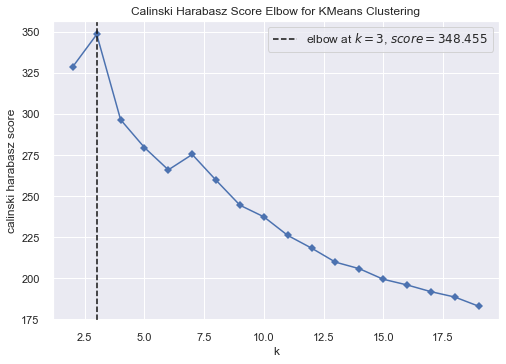

In [130]:
visualizer = KElbowVisualizer(model, k=(2,20), metric='calinski_harabasz',locate_elbow=True, timings=False)
visualizer.fit(reduced_data)
visualizer.show();

Each plot is giving a different outcome, 3 clusters for Calinski Harabasz Scores and 7 for Distortion Scores. To evaluate further, I will look at the Silhouette plots and Intercluster Distance plots to see which K forms better clusters.

### Evaluating K = 7
The intercluster distance map shows badly-separated clusters, and the silhouette plot shows wide variation in cluster size, though all are above the average silhouette score. Some of these clusters have better silhouette scores, such as cluster 1, and others have a bunch of observations that were probably clustered incorrectly (such as cluster 6). Next, we will evaluate the same model on K = 3.

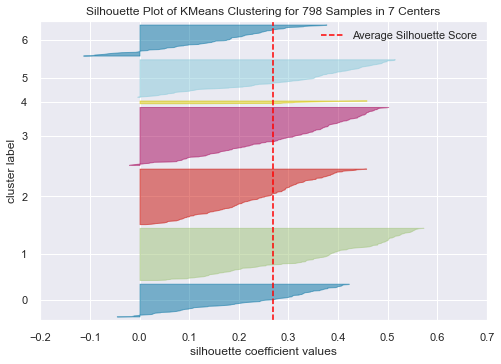

In [131]:
modeldist = KMeans(random_state=1, n_clusters = 7)

visualizer = SilhouetteVisualizer(modeldist, colors='yellowbrick')
visualizer.fit(reduced_data) 
visualizer.show();    

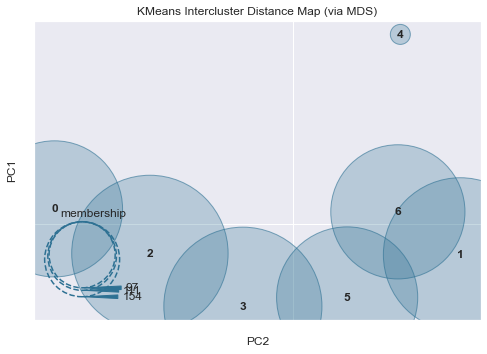

In [132]:
visualizer = InterclusterDistance(modeldist, colors='yellowbrick')
visualizer.fit(reduced_data) 
visualizer.show();    

### Evaluating K = 3
The intercluster distance map shows well-separated clusters, and the silhouette plot shows similarly sized clusters where all are above the average silhouette score. These scores are not as close to 1 as you might hope, which is likely due to a lack of density within the clusters. However, the separation between clusters is quite convincing, per the intercluster distance map. The silhouette plot does appear to show a small number of observations in cluster 0 that may be in the wrong cluster, since they are negative. However this problem is way more pronounced for K = 7. K = 3 appears to be the preferable option.

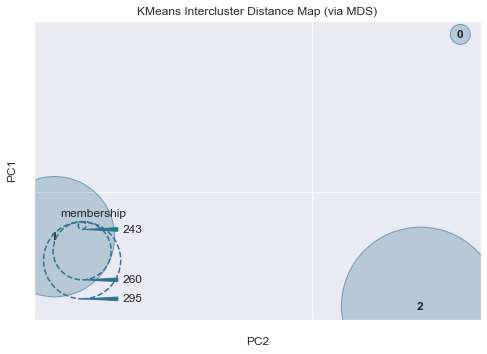

In [133]:
modelch = KMeans(random_state=1, n_clusters = 3)
visualizer = InterclusterDistance(modelch, colors='yellowbrick')
visualizer.fit(reduced_data) 
visualizer.show();    

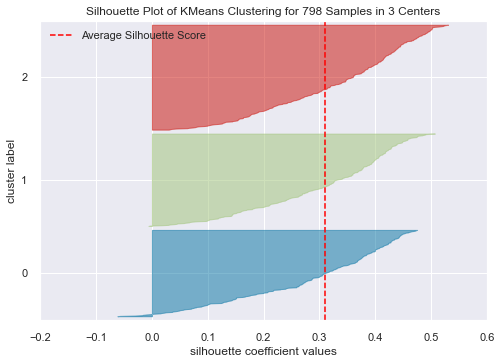

In [134]:
visualizer = SilhouetteVisualizer(modelch, colors='yellowbrick')
visualizer.fit(reduced_data) 
visualizer.show();    

### Examining Results


In [135]:
data_kmeans = pd.concat([X.reset_index(drop=True), pd.DataFrame(reduced_data)], axis = 1)
data_kmeans.columns.values[-6: ] = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
data_kmeans['K-Means Cluster'] = modelch.labels_

In [136]:
data_kmeans

,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,DP02_0026PE,...,THEFT,WEAPONS VIOLATION,inv_stop_count,PC1,PC2,PC3,PC4,PC5,PC6,K-Means Cluster
0,4599.0,23.8,2.5,39.5,34.2,21.5,8.7,1.89,25.4,64.4,...,467.0,43.0,3.0,1.152316,4.802506,0.926957,-0.415889,-0.864202,-3.558708,1
1,7455.0,33.7,7.2,28.3,30.8,28.2,14.9,2.65,34.5,55.3,...,431.0,18.0,18.0,-0.000559,1.341584,3.119024,0.139273,2.206346,-4.647192,2
2,2896.0,23.1,13.6,23.0,40.4,26.9,17.9,2.27,25.1,58.8,...,786.0,14.0,16.0,-0.408259,1.531138,0.897287,-0.787755,1.482906,-1.631048,2
3,6485.0,25.3,7.4,25.2,42.1,17.0,18.7,1.80,20.0,49.6,...,534.0,6.0,9.0,-0.677153,3.112343,1.285970,2.982166,1.873528,-2.478870,0
4,5213.0,17.4,5.7,36.4,40.5,12.5,10.7,1.82,16.8,75.1,...,390.0,10.0,39.0,-4.376502,5.742758,-0.333874,-1.081924,2.255026,-5.108578,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,10169.0,33.0,22.8,25.6,18.6,50.9,10.2,3.58,44.1,88.4,...,537.0,22.0,40.0,1.507523,-1.764229,4.024175,-4.982434,2.218716,1.334380,2
794,2898.0,12.5,8.8,18.9,59.7,28.4,20.9,2.06,32.5,48.1,...,412.0,14.0,35.0,1.102813,2.971443,-3.093318,-0.553831,-1.208696,-0.087675,1
795,2527.0,51.3,5.6,17.9,25.1,39.6,22.4,2.55,32.6,35.4,...,416.0,4.0,77.0,-4.360280,-0.465488,1.436803,-0.120577,-1.638675,2.831651,0
796,1520.0,19.8,9.5,31.9,38.8,32.4,32.5,2.23,31.1,50.6,...,293.0,35.0,41.0,3.881694,-0.446454,-2.564378,0.049996,0.433761,1.778111,1


#### Plotting First Two PCs Against Cluster

It appears that the first two principal components are enough to see the separation in the data, among clusters. There is some overlap, as expected, and at this dimension there appears to be relatively low levels of separation, although the clusters are well-formed.

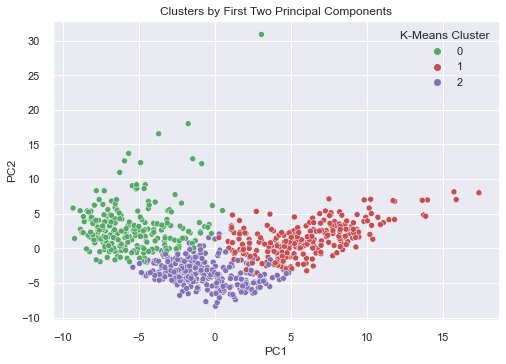

In [137]:
x_axis = data_kmeans['PC1']
y_axis = data_kmeans['PC2']
sns.scatterplot(x=x_axis, y=y_axis, hue = data_kmeans['K-Means Cluster'], palette = ['g', 'r', 'm'])
plt.title('Clusters by First Two Principal Components')
plt.show()


In [138]:
#Splitting into train and test
data_kmeans['any_complaints'] = np.where(data['complaint_count']>0, 1, 0)
data_kmeans['complaint_count'] = y.copy()

print('Complaint Count by cluster:\n',data_kmeans.groupby('K-Means Cluster').describe()['complaint_count'])
print('\nPolice stops by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['inv_stop_count'])
print('\nPercentage in Poverty by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP03_0119PE'])
print('\nWeapons Violations by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['WEAPONS VIOLATION'])


Complaint Count by cluster:
                  count      mean       std  min  25%  50%  75%   max
K-Means Cluster                                                     
0                243.0  0.576132  1.278140  0.0  0.0  0.0  1.0  11.0
1                260.0  1.288462  1.657282  0.0  0.0  1.0  2.0  12.0
2                295.0  0.583051  1.062207  0.0  0.0  0.0  1.0   8.0

Police stops by cluster:
                  count       mean        std  min   25%   50%   75%   max
K-Means Cluster                                                          
0                243.0  36.691358  14.212940  6.0  27.0  35.0  45.0  80.0
1                260.0  31.946154  12.116750  3.0  24.0  32.0  39.0  86.0
2                295.0  32.230508  13.457962  1.0  23.5  32.0  39.5  77.0

Percentage in Poverty by cluster:
                  count       mean        std  min    25%   50%    75%   max
K-Means Cluster                                                            
0                243.0   7.238272   8.413

Evaluating each Principal Component more closely, the five variables that contributed most to each principal component score were:
   - PC1: DP03_0098PE, The percentage of persons with public health insurance
   - PC2: DP02_0016E, The average household size
   - PC3: B01001_001E, The total population of the Census Tract
   - PC4: DP02_0077PE, Percentage of the civilian noninstitutionalized older age population with a disability
   - PC5: DP02_0093PE, Percentage of Census Tract population born abroad
   - PC6: DP02_0053PE, Percentage of population 3 or older and enrolled in school

In [147]:
pcaframe = abs(pd.DataFrame(pca.components_,columns=X.columns,index = ['PC1','PC2','PC3', 'PC4', 'PC5', 'PC6']))
print(f'The top most influential variables for each Principal Component were:\n{pcaframe.idxmax(axis = 1)}')

The top most influential variables for each Principal Component were:
PC1    DP03_0098PE
PC2     DP02_0016E
PC3    B01001_001E
PC4    DP02_0077PE
PC5    DP02_0093PE
PC6    DP02_0053PE
dtype: object


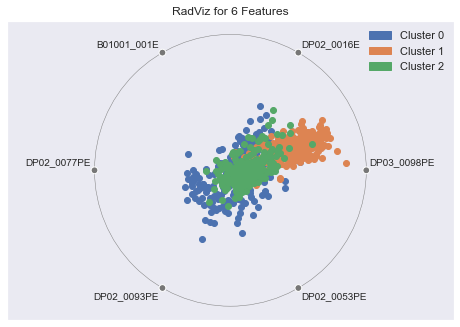

<AxesSubplot:title={'center':'RadViz for 6 Features'}>

In [148]:
PCA_y = data_kmeans['K-Means Cluster'].copy()
PCA_X = data_kmeans[['DP03_0098PE', 'DP02_0016E', 'B01001_001E', 'DP02_0077PE', 'DP02_0093PE', 'DP02_0053PE']].copy()

classes = ["Cluster 0", "Cluster 1", "Cluster 2"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes)
visualizer.fit(PCA_X, PCA_y)
visualizer.transform(PCA_X)  
visualizer.show()    

In [149]:
print('% Persons with Public Health Insurance:\n',data_kmeans.groupby('K-Means Cluster').describe()['DP03_0098PE'])
print('\nAverage household size:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0016E'])
print('\nTotal Population by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['B01001_001E'])
print('\n% Older Adults with a Disability:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0077PE'])
print('\n% People Born Abroad:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0093PE'])
print('\n% 3 and Older Enrolled in School:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0053PE'])


% Persons with Public Health Insurance:
                  count       mean        std   min    25%   50%     75%   max
K-Means Cluster                                                              
0                243.0  19.189712  11.094710   3.6  10.30  17.3  26.000  55.0
1                260.0  58.854615  10.217406  34.6  51.50  58.1  66.375  85.9
2                295.0  37.356610  10.343022  14.9  30.15  37.0  44.050  67.5

Average household size:
                  count      mean       std   min    25%   50%     75%   max
K-Means Cluster                                                            
0                243.0  2.070741  0.372105  1.33  1.725  2.08  2.3750  3.19
1                260.0  2.628231  0.452178  1.35  2.320  2.62  2.9425  3.88
2                295.0  3.025390  0.461942  1.65  2.660  2.99  3.3550  4.35

Total Population by cluster:
                  count         mean          std    min      25%     50%  \
K-Means Cluster                                         

## References

 - https://stackoverflow.com/questions/32860849/classification-pca-and-logistic-regression-using-sklearn
 - My in-class exercise on clustering: Clustering-Mini2_JamesonCarter
 - https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
 - https://365datascience.com/tutorials/python-tutorials/pca-k-means/
 - https://dl.acm.org/doi/10.1145/1015330.1015408
 - https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
